<a href="https://colab.research.google.com/github/AngKS/Deep-Learning-practices/blob/master/Functional_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import random
plt.style.use('seaborn')

print(tf.__version__)

2.8.2


In [2]:
# Load CIFAR100 Data

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [3]:
coarse_label = [
'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile','cup', 'dinosaur',
'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',
]

In [4]:
# Get shape of data

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (50000, 32, 32, 3)
y_train Shape: (50000, 1)
X_test Shape: (10000, 32, 32, 3)
y_test Shape: (10000, 1)


In [5]:
len(coarse_label)

100

In [6]:
# Get unique values of y_train
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
# function to generate 3 sample images of a random class
def generate_random_image():
  random25_class = [random.randint(0, 99) for i in range(25)]
  fig = plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(X_train[random25_class[i]])
    ax.set_title(f"Label: {coarse_label[y_train[random25_class[i]]]}", fontsize=10)
    
  plt.suptitle(f"25 Images of Random Classes", fontsize=15)
  plt.show()


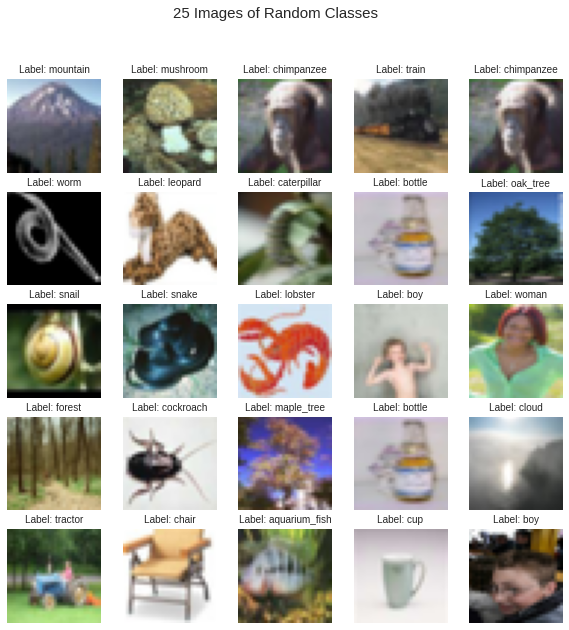

In [9]:
generate_random_image()

In [10]:
# Augmentation using imageDataGen
dataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function="normalize",
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)


In [11]:
# Normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# Encode labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [13]:
batch_size = 128
epochs = 20
num_classes = 100
input_shape = X_train.shape[1:]
depth = 64
learning_rate = 2e-3

# Resnet Model

Code is referenced from: https://keras.io/zh/examples/cifar10_resnet/

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import *

In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = learning_rate
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [16]:
# Create the Residual/Identity Block

def resnet_layer(inputs, num_filters=16, kernel_size=(3, 3), strides=1, activation='relu', batch_normalization=True, conv_first=True):
  conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
  
  x = inputs
  if conv_first:
      x = conv(x)
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
  else:
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
      x = conv(x)
  return x

In [17]:
def resnet_v1(input_shape, depth, num_classes=100):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs, name='resnet_V1')
    return model


In [18]:
model = resnet_v1(input_shape=input_shape, depth=32)

model.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(lr=lr_schedule(0)),
    metrics = ['accuracy']
)
model.summary()

Learning rate:  0.0003
Model: "resnet_V1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 batch_normalization_12 (BatchN  (None, 16, 16, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 16, 16, 32)   0           ['conv2d_13[0][0]',              
                                                                  'batch_normalization_12[0][0]'] 
                                                                                                  
 activation_12 (Activation)     (None, 16, 16, 32)   0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_12[0][0]']          
                                                                                                  
 batch_nor

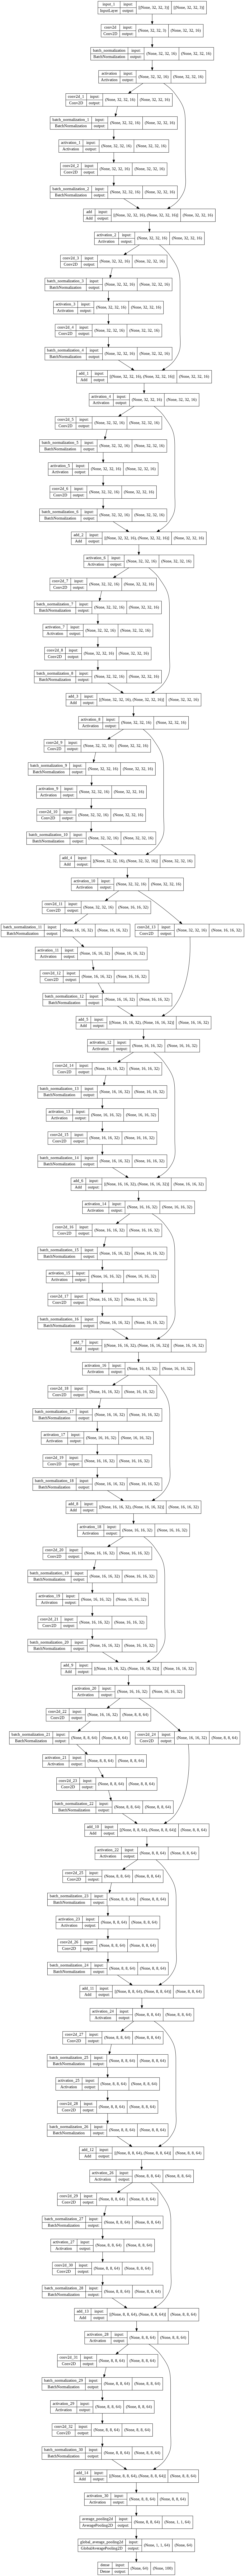

In [19]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png',
           show_shapes=True, show_layer_names=True)

In [20]:
from datetime import datetime
print(model.name)

resnet_V1


In [21]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath="./checkpoints",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_scheduler, lr_reducer]


In [22]:
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True, callbacks=callbacks)

Learning rate:  0.0003
Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 4.7134 - accuracy: 0.0632

391/391 [==============================] - 30s 51ms/step - loss: 4.7134 - accuracy: 0.0632 - val_loss: 4.3327 - val_accuracy: 0.0805 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 3.9066 - accuracy: 0.1481

391/391 [==============================] - 19s 49ms/step - loss: 3.9066 - accuracy: 0.1481 - val_loss: 3.8253 - val_accuracy: 0.1565 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 3/20
390/391 [============================>.] - ETA: 0s - loss: 3.5603 - accuracy: 0.2051

391/391 [==============================] - 20s 50ms/step - loss: 3.5602 - accuracy: 0.2052 - val_loss: 3.5891 - val_accuracy: 0.1988 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 4/20
390/391 [============================>.] - ETA: 0s - loss: 3.3205 - accuracy: 0.2451

391/391 [==============================] - 19s 48ms/step - loss: 3.3207 - accuracy: 0.2451 - val_loss: 3.5135 - val_accuracy: 0.2060 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 5/20
390/391 [============================>.] - ETA: 0s - loss: 3.1220 - accuracy: 0.2796

391/391 [==============================] - 19s 48ms/step - loss: 3.1215 - accuracy: 0.2798 - val_loss: 3.3084 - val_accuracy: 0.2501 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 6/20
391/391 [==============================] - ETA: 0s - loss: 2.9557 - accuracy: 0.3131

391/391 [==============================] - 19s 49ms/step - loss: 2.9557 - accuracy: 0.3131 - val_loss: 3.1513 - val_accuracy: 0.2747 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 7/20
390/391 [============================>.] - ETA: 0s - loss: 2.8097 - accuracy: 0.3405

391/391 [==============================] - 20s 51ms/step - loss: 2.8091 - accuracy: 0.3406 - val_loss: 3.2366 - val_accuracy: 0.2646 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 8/20
391/391 [==============================] - ETA: 0s - loss: 2.6849 - accuracy: 0.3672

391/391 [==============================] - 19s 49ms/step - loss: 2.6849 - accuracy: 0.3672 - val_loss: 3.0405 - val_accuracy: 0.2992 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 9/20
390/391 [============================>.] - ETA: 0s - loss: 2.5608 - accuracy: 0.3940

391/391 [==============================] - 19s 48ms/step - loss: 2.5614 - accuracy: 0.3940 - val_loss: 3.0914 - val_accuracy: 0.2885 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 10/20
391/391 [==============================] - ETA: 0s - loss: 2.4565 - accuracy: 0.4164

391/391 [==============================] - 19s 49ms/step - loss: 2.4565 - accuracy: 0.4164 - val_loss: 2.9558 - val_accuracy: 0.3208 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 11/20
390/391 [============================>.] - ETA: 0s - loss: 2.3570 - accuracy: 0.4352

391/391 [==============================] - 19s 49ms/step - loss: 2.3567 - accuracy: 0.4352 - val_loss: 3.1498 - val_accuracy: 0.2889 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 12/20
390/391 [============================>.] - ETA: 0s - loss: 2.2544 - accuracy: 0.4614

391/391 [==============================] - 19s 49ms/step - loss: 2.2544 - accuracy: 0.4614 - val_loss: 3.0153 - val_accuracy: 0.3136 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 13/20
390/391 [============================>.] - ETA: 0s - loss: 2.1663 - accuracy: 0.4805

391/391 [==============================] - 19s 49ms/step - loss: 2.1660 - accuracy: 0.4806 - val_loss: 3.0444 - val_accuracy: 0.3144 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 14/20
390/391 [============================>.] - ETA: 0s - loss: 2.0706 - accuracy: 0.5025

391/391 [==============================] - 19s 49ms/step - loss: 2.0706 - accuracy: 0.5024 - val_loss: 2.9995 - val_accuracy: 0.3255 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 15/20
391/391 [==============================] - ETA: 0s - loss: 1.9760 - accuracy: 0.5247

391/391 [==============================] - 19s 49ms/step - loss: 1.9760 - accuracy: 0.5247 - val_loss: 3.0265 - val_accuracy: 0.3225 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 16/20
390/391 [============================>.] - ETA: 0s - loss: 1.8970 - accuracy: 0.5430

391/391 [==============================] - 19s 49ms/step - loss: 1.8975 - accuracy: 0.5427 - val_loss: 3.0960 - val_accuracy: 0.3163 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 17/20
391/391 [==============================] - ETA: 0s - loss: 1.8163 - accuracy: 0.5617

391/391 [==============================] - 20s 50ms/step - loss: 1.8163 - accuracy: 0.5617 - val_loss: 3.0952 - val_accuracy: 0.3247 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 18/20
391/391 [==============================] - ETA: 0s - loss: 1.7342 - accuracy: 0.5820

391/391 [==============================] - 19s 48ms/step - loss: 1.7342 - accuracy: 0.5820 - val_loss: 3.2421 - val_accuracy: 0.3034 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 19/20
390/391 [============================>.] - ETA: 0s - loss: 1.6538 - accuracy: 0.6033

391/391 [==============================] - 19s 48ms/step - loss: 1.6537 - accuracy: 0.6034 - val_loss: 3.2780 - val_accuracy: 0.3105 - lr: 3.0000e-04
Learning rate:  0.0003
Epoch 20/20
391/391 [==============================] - ETA: 0s - loss: 1.5749 - accuracy: 0.6243

391/391 [==============================] - 19s 48ms/step - loss: 1.5749 - accuracy: 0.6243 - val_loss: 3.5978 - val_accuracy: 0.2940 - lr: 3.0000e-04


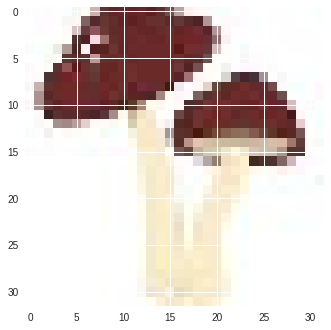

In [49]:
from tensorflow.keras.preprocessing.image import load_img


# load the image with the required shape
img = load_img('mushroom.jpg', target_size=(32, 32))
plt.imshow(img)

In [50]:
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import numpy as np

img = img_to_array(img)
img = expand_dims(img, axis=0)

img.shape


(1, 32, 32, 3)

In [51]:
def recursiveSearch(resultArr, labelArr):
    if (resultArr[0] > 0):
        return labelArr[0]
    
    return recursiveSearch(resultArr[1:], labelArr[1:])

In [52]:
result = model.predict(img)

print(recursiveSearch(result[0], coarse_label))

chair
